In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os as os
from sklearn.cluster import KMeans
# enter data
filename = 'D:\jupiter-enviromnet\data\\rooms.csv'
print(filename)
df = pd.read_csv(filename)
df['Room'] = df['Room'].apply(str)
print(df.dtypes)

D:\jupiter-enviromnet\data\rooms.csv
Floor        object
Room         object
Zone        float64
Metric       object
Unit         object
Value       float64
DateTime     object
Duration    float64
Date         object
Time         object
dtype: object


In [2]:
#dealing with time
df.drop(['Floor', 'Zone', 'Unit', 'Date'], axis=1, inplace=True)
df['Time'] = pd.to_datetime(df['Time'],format='%H:%M:%S')
df['DateTime'] = pd.to_datetime(df['DateTime'],format='%Y-%m-%d %H:%M:%S')

In [3]:
#handle rooms & sensors
rooms = (df['Room'].unique())
print(rooms)
sensors = (df['Metric'].unique())
test = (df['Metric'].unique())
data = {}
print(sensors)
for room in rooms:
    data[room] = pd.DataFrame(columns = df.columns)
for room in rooms:
    data[room] = pd.concat([data[room],df.loc[df['Room'] == room]])

['2.008' 'G.069' '3.005' '6.031']
['Actual Cooling Set point' 'Actual Heating Set point'
 'Chilled Water Valve' 'CO2' 'Cooling Set Point' 'Cooling Valve Position'
 'Heating Set Point' 'Heating Valve Position' 'HVAC Operating Mode'
 'Light Power Level' 'Low Temperature Hot Water Valve' 'Mode' 'Mode Input'
 'Occupancy Sensor' 'Relative Humidity' 'Room Brightness' 'Room Occupied'
 'Room Temperature' 'BrightnessValueZ2' 'FanSpeed']


In [4]:
#dropping info we wish to remobe
sensors = ['Actual Cooling Set point', 'Actual Heating Set point',
 'Chilled Water Valve', 'Cooling Set Point', 'Cooling Valve Position',
 'Heating Set Point', 'Heating Valve Position', 'HVAC Operating Mode',
 'Low Temperature Hot Water Valve', 'Mode', 'Mode Input',
 'Occupancy Sensor', 'BrightnessValueZ2', 'FanSpeed', 'Room Occupied', 'Light Power Level']

for room in rooms:
    data[room].drop(['Room'], axis=1, inplace=True)
    for sen in sensors:
        data[room] = data[room].drop(
            index=(list(data[room]['Metric'][data[room]['Metric'] == sen].index)))
    data[room].reset_index(drop=True, inplace=True) 
    

In [5]:
from sklearn import preprocessing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pca = PCA(n_components = 2) 
minmax_scale = preprocessing.MinMaxScaler(feature_range=(1, 2))

train = {}
test = {}
scaler = StandardScaler()
# #scaling            
for room in rooms:
    data[room]['Time'] = scaler.fit_transform(data[room]['Time'].values.reshape(-1,1))
    
    #data[room] = encoder.fit_transform(data[room])
    
    #temp = pca.fit_transform(data[room][['Value','Duration','Time']])
    #temp = pd.DataFrame(temp)
    
    data[room]['P1'] = data[room]['Value']
    data[room]['P2'] = data[room]['Time']
    # standardize these 2 new features
    
    splitData = []
    print(data[room]['Metric'].unique())
    for sen in (data[room]['Metric'].unique()):
        
        splitData.append(data[room].loc[(data[room]['Metric'] == sen)])
        
        
        #print(sen)
    
    scaledSenData = []
    
    for senData in splitData:
        senData.reset_index(drop=True, inplace=True)
        np_scaled = scaler.fit_transform(senData[['P1']])
        senData[['P1']] = pd.DataFrame(np_scaled)  
        scaledSenData.append(senData)
        #print(senData)
    #print(splitData[1])
    data[room] = []
    data[room] = pd.concat(scaledSenData)
    
    #print(data[room].loc[(data[room]['Metric'] == 'Room Brightness')])

    #test and traing sets
    train[room], test[room] = train_test_split(data[room], test_size=0.20)

    #reset index
    train[room].reset_index(drop=True, inplace=True) 
    test[room].reset_index(drop=True, inplace=True) 
    
    
    

['CO2' 'Relative Humidity' 'Room Brightness' 'Room Temperature']
['CO2' 'Relative Humidity' 'Room Temperature']
['CO2' 'Relative Humidity' 'Room Temperature']
['CO2' 'Relative Humidity' 'Room Brightness' 'Room Temperature']


In [6]:
print(len(data['2.008']))

53876


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


#k-means
km = KMeans(
    init='k-means++',
    n_clusters=6,
    n_init=20,
    max_iter=20,
)

#train 3 data sets
model2 = km.fit(train['2.008'][['P1', 'P2']])
model6 = km.fit(train['6.031'][['P1', 'P2']])
modelG = km.fit(train['G.069'][['P1', 'P2']])


models = [model2, model6, modelG]

In [8]:
def getDistanceByPoint(datat, model):
    distance = pd.Series(dtype = float)
    for i in range(0,len(datat)):
        Xa = np.array(datat.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [9]:
# yeet = data['G.069'].copy()
# outliers_fraction = 0.01
# yeet.reset_index(drop=True, inplace=True) 
# models[0].fit_predict(yeet[['P1', 'P2']])

# distance = getDistanceByPoint(yeet[['P1', 'P2']], models[0])
# number_of_outliers = int(outliers_fraction*len(distance))
# threshold = distance.nlargest(number_of_outliers).min()
# yeet['a1'] = (distance >= threshold).astype(int)

# yeet.to_csv('G.069.csv')


In [10]:
import time
#validatyion on testing sets
outliers_fraction = 0.01
rooms = ['2.008', 'G.069', '6.031']
tests = []
i = 0
thresholds = []
for model in models:
    start = time.time()
    tests.append(model.predict(test[rooms[i]][['P1', 'P2']]))
    # get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
    
    distance = getDistanceByPoint(test[rooms[i]][['P1', 'P2']], model)
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()
    thresholds.append(threshold)
    # anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
    test[rooms[i]]['a1'] = (distance >= threshold).astype(int)
    end = time.time()
    print(end - start)
    i += 1

8.301357984542847
2.4630677700042725
6.3026299476623535


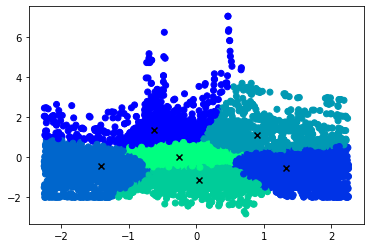

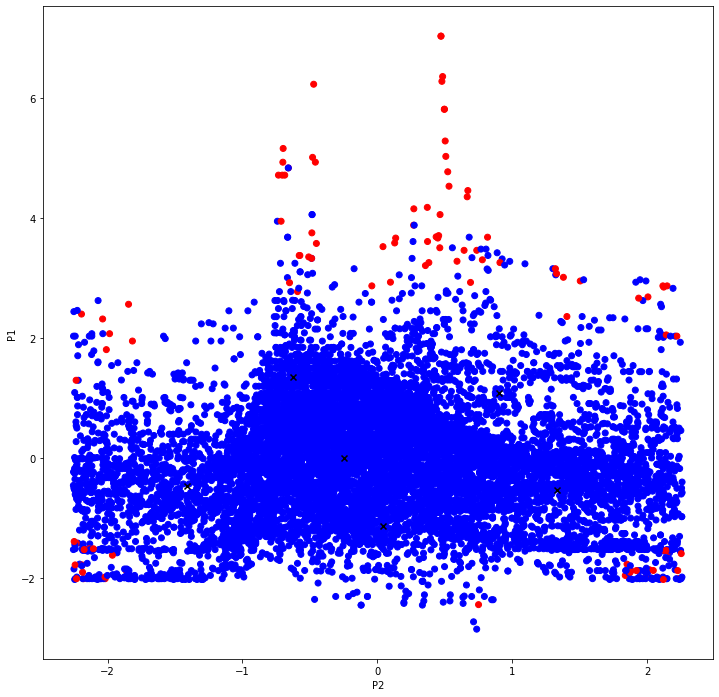

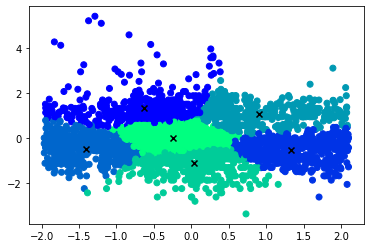

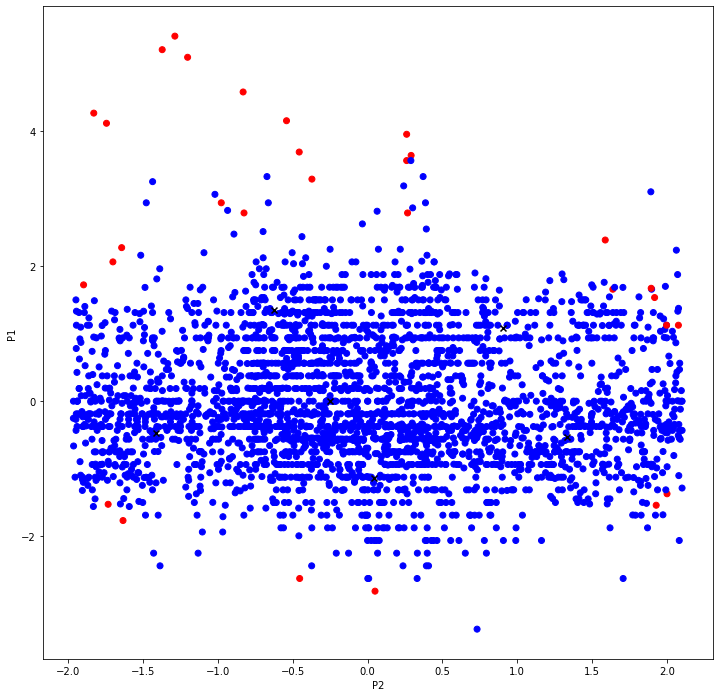

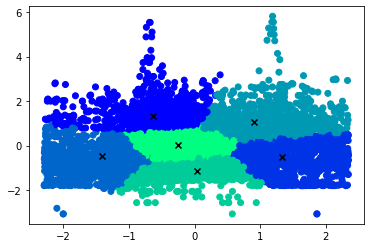

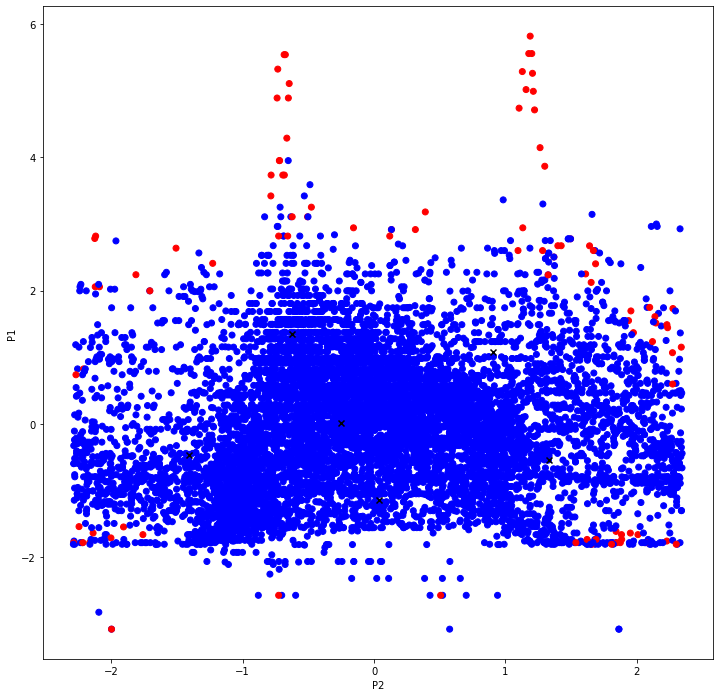

In [11]:
#visual validation
i = 0
for model in models:
    centers = np.array(model.cluster_centers_)
    plt.scatter(test[rooms[i]]['P2'], test[rooms[i]]['P1'], c = tests[i], cmap =plt.cm.winter) 
    plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
    plt.show()

    fig, ax = plt.subplots(figsize=(12,12))
    colors = {0:'blue', 1:'red'}
    ax.scatter(test[rooms[i]]['P2'], test[rooms[i]]['P1'], c=test[rooms[i]]["a1"].apply(lambda x: colors[x]))
    plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
    plt.xlabel('P2')
    plt.ylabel('P1')
    plt.show();
    
    i += 1

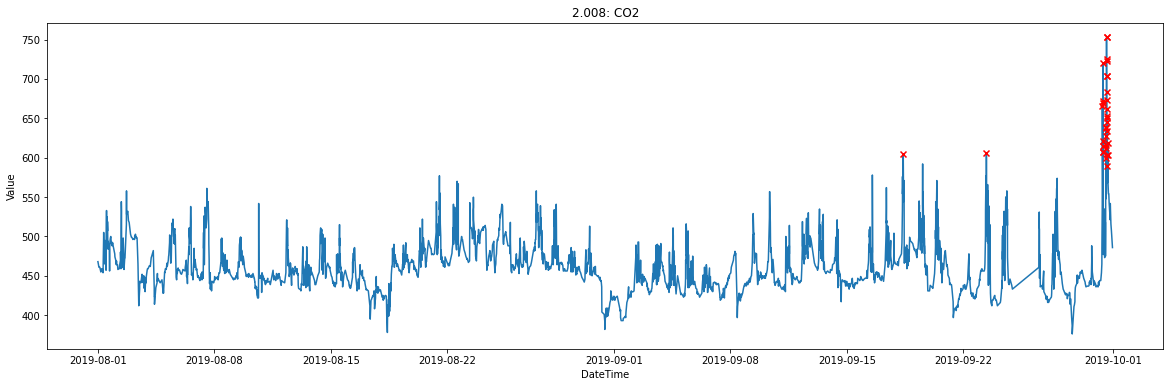

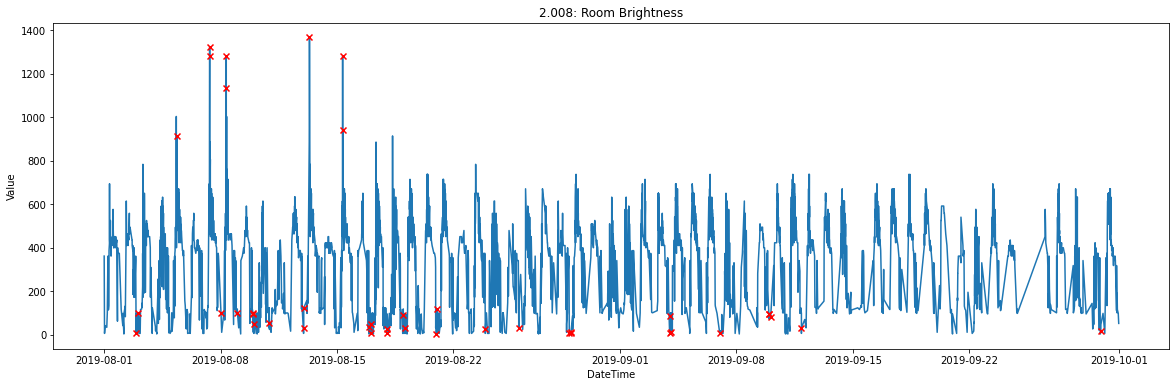

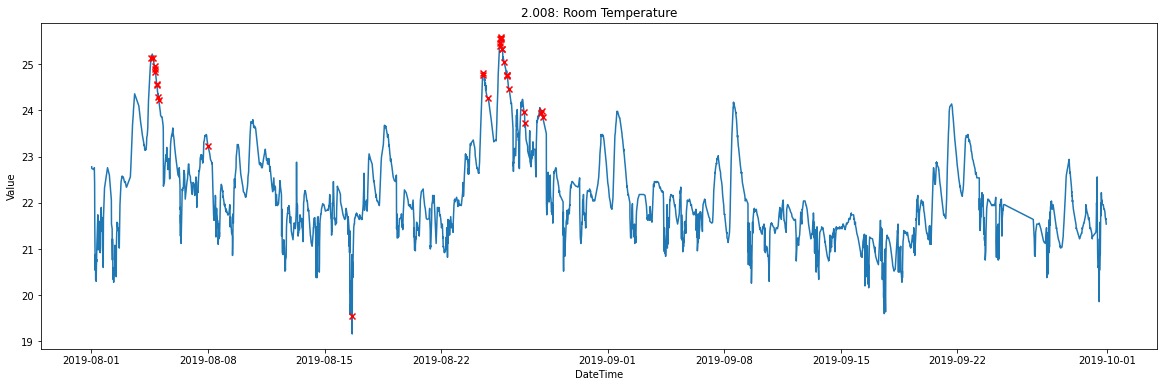

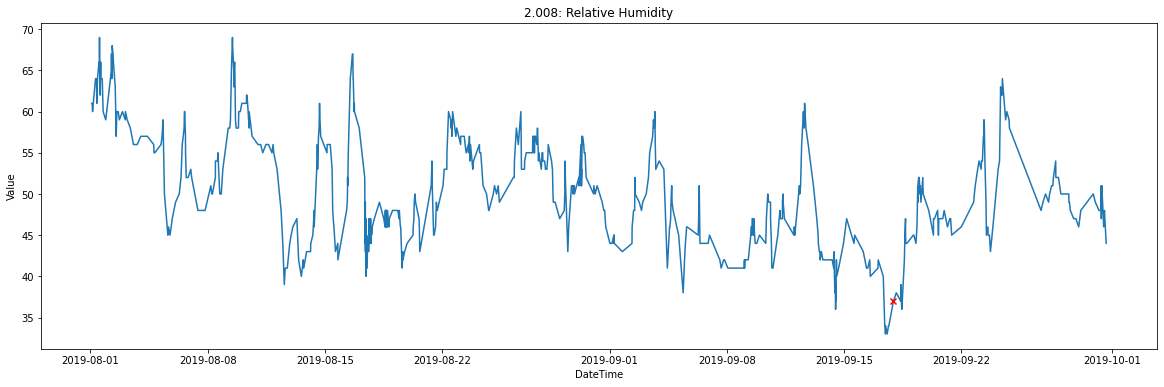

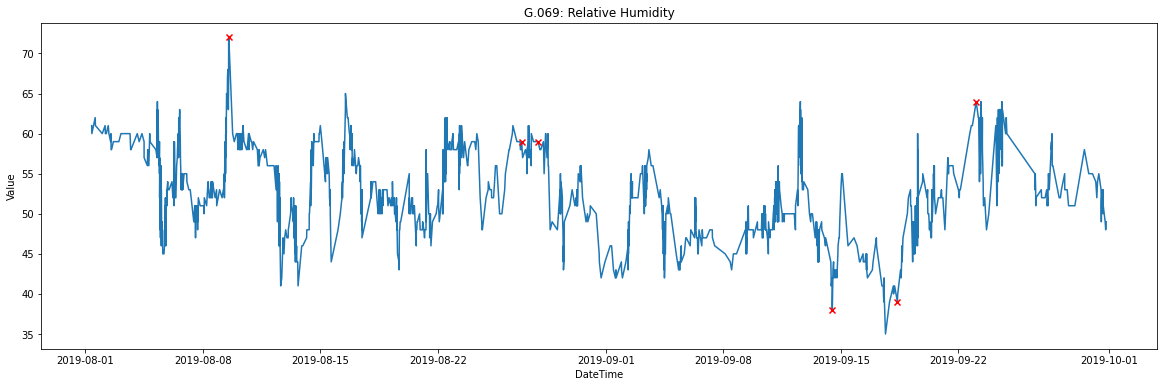

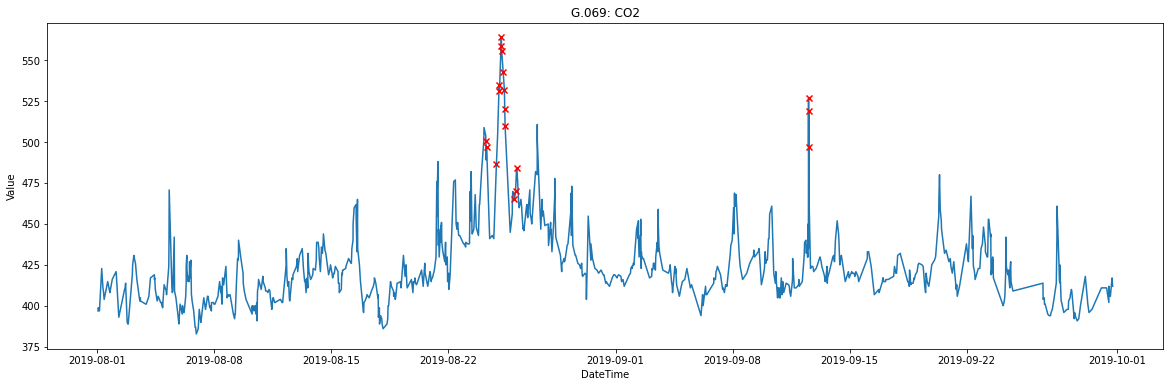

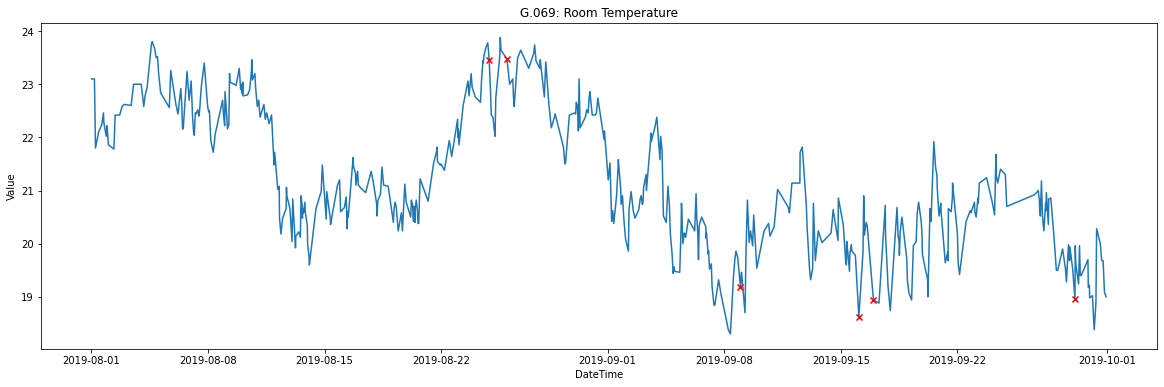

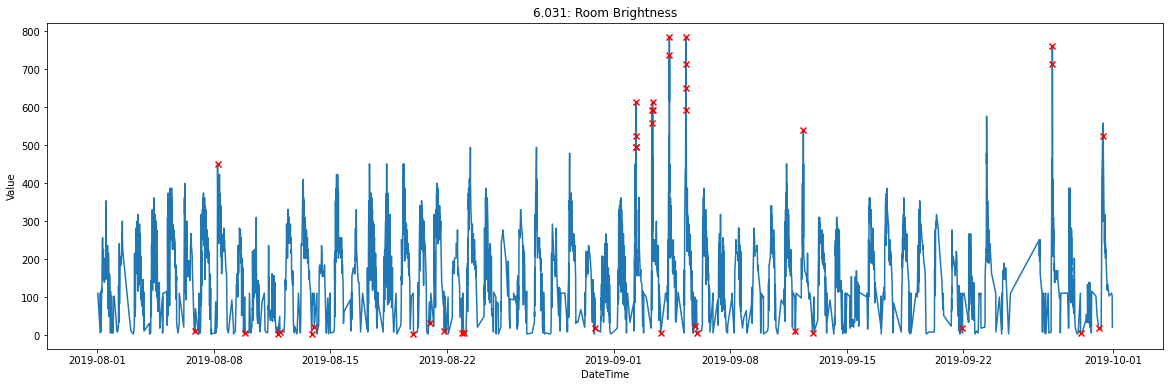

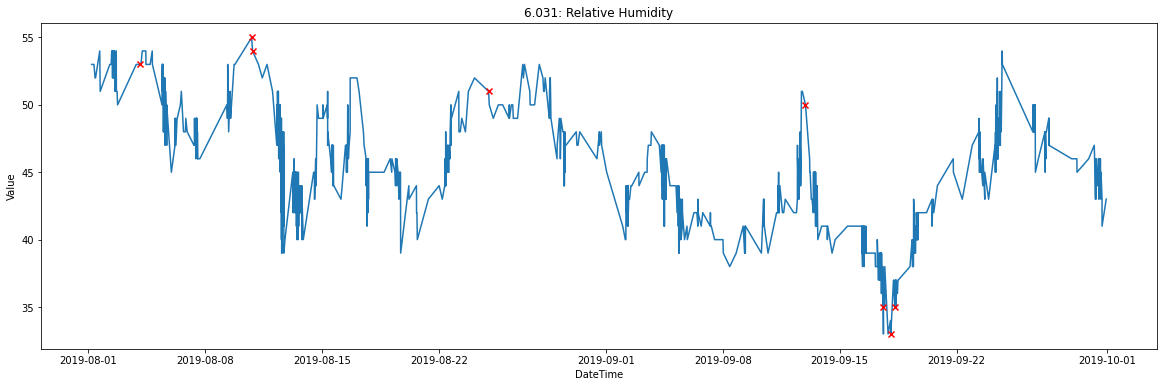

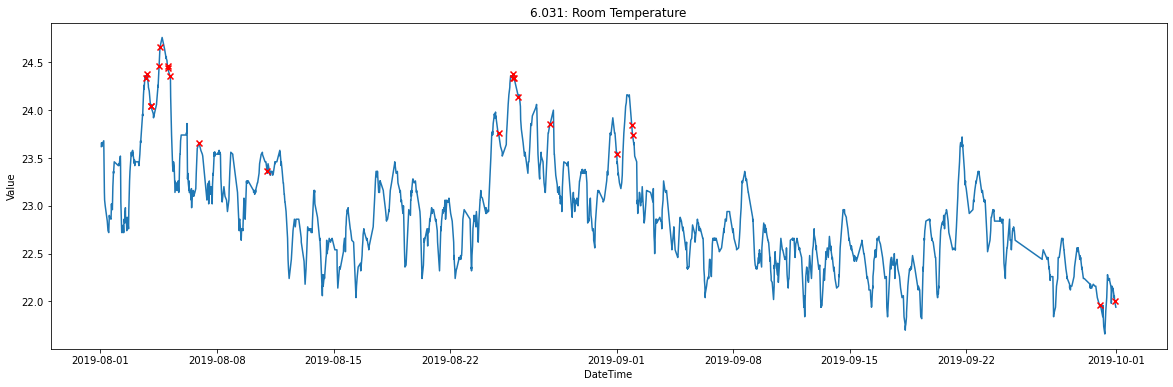

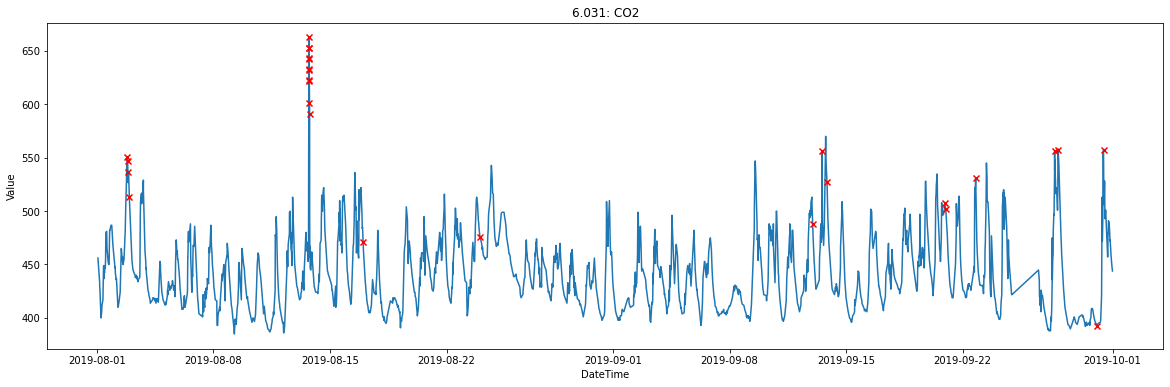

In [12]:
for room in rooms:
    sub = test[room].copy()
    for metric in (sub['Metric'].unique()):
        plt.figure(figsize=(20,6))
        plt.title(room + ': ' + metric)
        a = sub.loc[(sub['a1'] == 1) & (sub['Metric'] == metric), ['DateTime', 'Value']]
        dataGraph = sub.loc[(sub['Metric'] == metric), ['DateTime', 'Value']]
        plt.scatter(a['DateTime'], a['Value'] , marker="x", zorder = 10, color='red')
        sns.lineplot(dataGraph['DateTime'],dataGraph['Value'], zorder = 0)
        plt.show();

# Add label for horizontal axis


In [13]:
# #hyper poramiter training
# #n_clusters
# newData = data['2.008'][['P1', 'P2']]
# n_cluster = range(1, 10)
# kmeans = [KMeans(n_clusters=i).fit(newData) for i in n_cluster]
# scores = [kmeans[i].score(newData) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(10,5))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters', fontname="Times New Roman",fontweight="bold")
# plt.ylabel('Score',fontname="Times New Roman",fontweight="bold")
# plt.title("Elbow Curve",fontname="Times New Roman",fontweight="bold")
# plt.show();

# #n_init
# newData = data['2.008'][['P1', 'P2']]
# n_cluster = range(5, 50)
# kmeans = [KMeans(n_clusters=6, n_init=i).fit(newData) for i in n_cluster]
# scores = [kmeans[i].score(newData) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(20,6))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters', fontname="Times New Roman",fontweight="bold")
# plt.ylabel('Score',fontname="Times New Roman",fontweight="bold")
# plt.title("Elbow Curve",fontname="Times New Roman",fontweight="bold")
# plt.show();

# #maxittorator
# newData = data['2.008'][['P1', 'P2']]
# n_cluster = range(1, 100)
# kmeans = [KMeans(n_clusters=6, n_init=19, max_iter=i).fit(newData) for i in n_cluster]
# scores = [kmeans[i].score(newData) for i in range(len(kmeans))]

# fig, ax = plt.subplots(figsize=(20,6))
# ax.plot(n_cluster, scores)
# plt.xlabel('Number of Clusters', fontname="Times New Roman",fontweight="bold")
# plt.ylabel('Score',fontname="Times New Roman",fontweight="bold")
# plt.title("Elbow Curve",fontname="Times New Roman",fontweight="bold")
# plt.show();

In [ ]:
#hour manipulation

#scales data separatly per metric and concats back
def ScaleData(data):
    #scale new data
    data['P1'] = data['Value']
    data['P2'] = data['Time']
            
    splitData = []
    for sen in (data['Metric'].unique()):
        splitData.append(data.loc[(data['Metric'] == sen)])
            
    scaledSenData = []
    for senData in splitData:
        senData.reset_index(drop=True, inplace=True)
        np_scaled = scaler.fit_transform(senData[['P1']])
        senData[['P1']] = pd.DataFrame(np_scaled)  
        scaledSenData.append(senData)
        
    
    data = []
    data = pd.concat(scaledSenData)
    data.reset_index(drop=True, inplace=True)
    return data

#predicts if the given data is anomalys
def predictData(data, i):
    
    #grab relivent data
    data.reset_index(drop=True, inplace=True)
    snipetResults = models[i].predict(data[['P1', 'P2']])    
    distance = getDistanceByPoint(data[['P1', 'P2']], models[i])
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()     
    data['a1'] = (distance >= threshold).astype(int)
    
    cut1 = data.loc[(data['e'] == 1)]
    cut2 = data.loc[(data['e'] == 2)]
    
    snippet = pd.concat([cut1, cut2])
    return snippet

#presents the data, not used here but good for debugging
def presentData(data, i):
    centers = np.array(models[i].cluster_centers_)
    fig, ax = plt.subplots(figsize=(3,3))
    colors = {0:'blue', 1:'red'}
    #print(data.head(10))
    ax.scatter(data['P2'], data['P1'], c=data["a1"].apply(lambda x: colors[x]))
    plt.scatter(centers[:,1], centers[:,0], marker="x", color='black')
    plt.xlabel('P2')
    plt.ylabel('P1')
    plt.show();


#selects data for a given hour
def selectData(data, room):
    data['e'] = 0 
    data.reset_index(drop=True, inplace=True)
    #find month
    snipet = data.copy()
    h = snipet['DateTime'].dt.month
    snipet = snipet[h.eq(9)]

    #find day
    h = snipet['DateTime'].dt.day
    snipet = snipet[h.eq(11)]

    #find hour
    h = snipet['DateTime'].dt.hour
    snipet = snipet[h.eq(13)] 
    
    for index in snipet.index.values:
        data.loc[index,'e'] = 1
    data.reset_index(drop=True, inplace=True)
    
    return data
    
#copys relivent data  
data = test.copy()
    

i = 0
#getting new data so re making the anomaly colomb
for room in (['2.008', '6.031', 'G.069']):
    models[i].predict(train[room][['P1','P2']])
    train[room].reset_index(drop=True, inplace=True)
    distance = getDistanceByPoint(data[room][['P1', 'P2']], models[i])
    number_of_outliers = int(outliers_fraction*len(distance))
    threshold = distance.nlargest(number_of_outliers).min()  
    data[room]['a1'] = (distance >= threshold).astype(int)
    i += 1

# index for models
i = 0
#loop through each dataset
for room in (['2.008', 'G.069', '6.031']):
    #for each sensor
    for sen in (data[room]['Metric'].unique()):
        #select data here
        data = dict(test)
        data[room] = selectData(data[room], room)
        data[room].reset_index(drop=True, inplace=True)

        #grabs relivent data for the hour we are looking for
        cut1 = data[room].loc[(data[room]['e'] == 1)]

        #if the hour does not have sensor data that we are looking for add it
        #mean values used as starting poinds
        if(cut1.loc[(cut1['Metric'] == sen)].empty):
            value = 0
            if(sen == 'CO2'):
                value = 470
            if(sen == 'Relative Humidity'):
                value = 50
            if(sen == 'Room Temperature'):
                value = 22
            if(sen == 'Room Brightness'):
                value = 386
            data[room].loc[len(data[room].index)] = [sen,  value,
                              pd.to_datetime('2019-09-11 13:42:20.017000+00:00',format='%Y-%m-%d %H:%M:%S') 
                              , -4.003, 0.323917, 7.361273, 0.323917,   0,  1]
            cut1 = data[room].loc[(data[room]['e'] == 1)]
        
        #takes relivent data to find the right metric
        cut2 = cut1.loc[(cut1['Metric'] == sen)]
        index = (cut2.index.values)[0]
        data[room].loc[index,'e'] = 2      
    
        #test outcome of change in data
        while(data[room].iloc[((data[room].loc[(data[room]['e'] == 2)]).index.values)[0]]['a1'] == 0):
            
            #room brightness has a larger range so the incroment is much bigger
            if(data[room].iloc[((data[room].loc[(data[room]['e'] == 2)]).index.values)[0]]['Metric'] == 'Room Brightness'):
                data[room].loc[((data[room].loc[(data[room]['e'] == 2)]).index.values)[0],'Value'] -= 100
            
            #regular incroment
            else:
                data[room].loc[((data[room].loc[(data[room]['e'] == 2)]).index.values)[0],'Value'] -= 1
            
            #scale data
            data[room] = ScaleData(data[room]).copy()
            
            #predict data
            snipet = predictData(data[room], i).copy()
            
            #report data if now anomalus
            var = snipet.loc[snipet['e'] == 2]
            if(var.iloc[0]['a1'] == 1):
                print('\n\nReport: ' + room)
                print(var)
                break  
    i += 1

print('\n\ndone')


In [ ]:
#mean of value and duration
print('##########################################')
print('Means: ')

for room in (['2.008', 'G.069', '6.031']):
    #for each sensor
    for sen in (data[room]['Metric'].unique()):
        print(room + ' ' + sen)
        print(data[room].loc[(data[room]['Metric'] == sen)]['Value'].mean())
        print('\n')
        


In [ ]:
import math
def deviation(value, mean, observations):
    return math.sqrt((((int)(value) - (int)(mean))^2)/((int)(observations)-1))


print('CO2: ' + (str)(deviation(577.92, 472, 3081)))
print('Relative Humidity: ' + (str)(deviation(71.0, 49.9, 845)))
print('Room Brightness: ' + (str)(deviation(1136.2, 389, 4204)))
print('Room Temperature: ' + (str)(deviation(25, 21.9, 2646)))


